# Project title: Diabet Prediction [notebook 'Diabet_Prediction_Models']

## Authors: Denys Herasymuk & Yaroslav Morozevych

## Contents of This Notebook

Click on the section and go to this cell immediately. (works only with Jupyter in browser)

* [Section 1. Explore Data](#section_1)
* [Section 2. Train and Validate Models](#section_2)
* [Section 3. Test Set Evaluation](#section_3)

When you use `Run All` button with this notebook, you should wait approx. 3-5 mins to get output of all cells.

**How to run this notebook**

* Create a new virtual env with python 3.8
* In terminal run  -- `pip install -r requirements.txt`

## General Configuration

In [1]:
import os
import sys
import math
import pickle
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgbm
import matplotlib.pyplot as plt

from pprint import pprint
from copy import deepcopy
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from utils import scale_normalize

2022-01-16 18:27:41.334713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 18:27:41.334739: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


In [2]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

# import warnings
# warnings.filterwarnings('ignore')

## Python & Library Versions

In [3]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__),
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.5
seaborn     0.11.2
sklearn     1.0.1


<a id='section_1'></a>

## Section 1. Explore Data

In [4]:
# diabetes_df = pd.read_csv(os.path.join(".", "data", "diabetes_processed.csv"))
diabetes_df = pd.read_csv(os.path.join(".", "data", "diabetes_cleaned.csv"))
diabetes_df = diabetes_df.iloc[: , 1:] # Drop first column of dataframe

In [5]:
diabetes_df.head()

,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
0,6,148,35,0,33.6,0.627,50,1.880,1
1,1,85,29,0,26.6,0.351,31,0.882,0
2,1,89,23,94,28.1,0.167,21,0.240,0
3,0,137,35,168,43.1,2.288,33,1.870,1
4,3,78,32,88,31.0,0.248,26,0.240,1


### Validate Data

In [6]:
diabetes_df.describe()

,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.510242,119.903166,29.186220,113.960894,32.890130,0.501823,31.586592,0.957773,0.333333
std,3.304281,32.975142,10.505807,122.894735,6.875842,0.343643,10.747286,0.528672,0.471844
min,0.000000,0.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000,0.000000
25%,1.000000,97.000000,22.000000,0.000000,27.800000,0.259000,23.000000,0.552000,0.000000
50%,2.000000,115.000000,29.000000,90.000000,32.800000,0.415000,28.000000,0.878000,0.000000
75%,5.000000,141.000000,36.000000,165.000000,36.900000,0.658000,38.000000,1.328000,1.000000
max,17.000000,199.000000,99.000000,846.000000,67.100000,2.420000,81.000000,2.110000,1.000000


In [7]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
DiabetesRisk                0
Outcome                     0
dtype: int64

In [8]:
# Selecting duplicate rows except first.
# Occurrence based on all columns
duplicates = diabetes_df[diabetes_df.duplicated()]

print("Duplicate rows :")
duplicates

Duplicate rows :


,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome


<a id='section_2'></a>

## Section 2. Dataframe Balancing & Split dataframe on features and target

In [9]:
# choose the most relevant features based on data analysis in 01_Process_Data_and_EDA.ipynb
features = ["Pregnancies", "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "DiabetesRisk", "Outcome"]
scaled_df = scale_normalize(df=diabetes_df, features=features)

In [10]:
# separate the dataframe onto features and target
features_df = scaled_df.drop("Outcome", axis="columns")
target_df = diabetes_df[['Outcome']]

In [11]:
SEED = 25
n_folds = 3

# split the data on test and train
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
samples_per_fold = len(y_test)
X_train.describe()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.026907,-0.015174,-0.000175,-0.023233,0.003571,0.010063,0.005302
std,1.018347,0.969375,0.982606,0.981235,0.990420,1.000519,1.002535
min,-1.063322,-3.639559,-0.928170,-2.138477,-1.214084,-0.985966,-1.813348
25%,-0.760402,-0.664852,-0.928170,-0.740982,-0.716011,-0.706566,-0.768248
50%,-0.457482,-0.179186,-0.178863,-0.013120,-0.247065,-0.334032,-0.151034
75%,0.754197,0.610022,0.431984,0.569169,0.498588,0.597303,0.700950
max,4.086316,2.400917,5.131437,3.553402,5.322033,4.602044,2.181508


### Random over-sampling with imblearn

In [12]:
target_df.value_counts()

Outcome
0          358
1          179
dtype: int64

In [13]:
y_train.value_counts()

Outcome
0          291
1          138
dtype: int64

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=SEED)

# fit predictor and target variable
# x_ros, y_ros = ros.fit_resample(features_df, target_df)
ros_X_train, ros_y_train = ros.fit_resample(X_train, y_train)

print('Original dataset shape', len(y_train))
print('Resample dataset shape', len(ros_y_train))
ros_y_train.value_counts()

Original dataset shape 429
Resample dataset shape 582


Outcome
0          291
1          291
dtype: int64

In [15]:
# ros_X_train, ros_X_test, ros_y_train, ros_y_test = train_test_split(x_ros, y_ros, test_size=0.2, random_state=SEED)

### Synthetic Minority Oversampling Technique (SMOTE)

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)

# fit predictor and target variable
# x_smote, y_smote = smote.fit_resample(features_df, target_df)
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)

print('Original dataset shape', len(y_train))
print('Resample dataset shape', len(smote_y_train))
smote_y_train.value_counts()
# smote_X_train, smote_X_test, smote_y_train, smote_y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=SEED)

Original dataset shape 429
Resample dataset shape 582


Outcome
0          291
1          291
dtype: int64

<a id='section_3'></a>

## Section 3. Train and Validate Models

In [17]:
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [18]:
def folds_iterator(n_folds, samples_per_fold, size):
    """
    Iterator for GridSearch based on Cross-Validation

    :param n_folds: number of folds for Cross-Validation
    :param samples_per_fold: number of samples per fold
    """
    for i in range(n_folds):
        yield np.arange(0, size - samples_per_fold * (i + 1)), \
              np.arange(size - samples_per_fold * (i + 1), size - samples_per_fold * i)


In [19]:
def validate_model(model, x, y, params, n_folds, samples_per_fold):
    """
    Use GridSearchCV for a special model to find the best hyperparameters based on validation set
    """
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               scoring={
                                   "F1_Score": make_scorer(f1_score, average='macro'),
                                   "Accuracy_Score": make_scorer(accuracy_score),
                               },
                               refit="F1_Score",
                               n_jobs=-1,
                               cv=folds_iterator(n_folds, samples_per_fold, x.shape[0]))
    grid_search.fit(x, y.values.ravel())
    best_index = grid_search.best_index_

    return grid_search.best_estimator_,\
           grid_search.cv_results_["mean_test_F1_Score"][best_index],\
           grid_search.cv_results_["mean_test_Accuracy_Score"][best_index],\
           grid_search.best_params_


def test_evaluation(cur_best_model, model_name, cur_best_params,
                    cur_x_train, cur_y_train, cur_x_test, cur_y_test,
                    dataset_title, show_plots, debug_mode):
    cur_best_model.fit(cur_x_train, cur_y_train.values.ravel()) # refit model on the whole train set
    cur_model_pred = cur_best_model.predict(cur_x_test)
    test_f1_score = f1_score(cur_y_test, cur_model_pred, average='macro')
    test_accuracy = accuracy_score(cur_y_test, cur_model_pred)

    if debug_mode:
        print("#" * 20, f' {dataset_title} ', "#" * 20)
        print('Test model: ', model_name)
        print('Test model parameters:')
        pprint(cur_best_params)

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        if show_plots:
            # plot the confusion matrix
            cm = confusion_matrix(cur_y_test, cur_model_pred, labels=cur_best_model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
            disp.plot()
            plt.show()
    return test_f1_score, test_accuracy, cur_model_pred


#### Validate ML Models

In this part we find the best ML model among RandomForestClassifier, DecisionTreeClassifier and SVM.

In [20]:
def test_ML_models(best_results_df, X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode):
    """
    Find the best model from defined list.
    Tune each model on a validation set with GridSearchCV and
    return best_model with its hyperparameters, which has the highest F1 score
    """
    results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    config_models = [
        {
            'model_name': 'RandomForestClassifier',
            'model': RandomForestClassifier(random_state=SEED),
            'params': {
                "bootstrap": [True, False],
                "max_depth": [3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "n_estimators": [5 * i for i in range(1, 7)],
                "max_features": [0.6, 'auto', 'sqrt']
            }
        },
        {
            'model_name': 'DecisionTreeClassifier',
            'model': DecisionTreeClassifier(random_state=SEED),
            'params': {
                "max_depth": [2, 3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "max_features": [0.6, 'auto', 'sqrt'],
                "criterion": ["gini", "entropy"]
            }
        },
        {
            'model_name': 'SVC',
            'model': SVC(random_state=SEED),
            'params': {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf'],
                # 'class_weight': ['balanced'], # shown bad performance
            }
        },

        # For XGBoost parameters tuning we used this article --
        # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
        #
        # For faster running this notebook we left only the best combination of parameters,
        # but for experiments e used next ones:
        # 'params': {
        #     'learning_rate': [0.1],
        #     'n_estimators': [100],
        #     'max_depth': range(3,10,2),
        #     'min_child_weight': range(1,6,2),
        #     'gamma': [i/10.0 for i in range(0,5)],
        #     'objective':  ['binary:logistic'],
        #     'nthread': [8]
        # }
        #
        {
            'model_name': 'XGBClassifier',
            'model': XGBClassifier(random_state=SEED),
            'params': {
                'learning_rate': [0.1],
                'n_estimators': [100],
                'max_depth': [4],
                'min_child_weight': [1],
                'gamma': [0.3],
                'objective':  ['binary:logistic'],
                'nthread': [8]
            }
        },
    ]

    best_f1_score = -np.Inf
    best_accuracy = -np.Inf
    best_model_pred = []
    best_model_name = 'No model'
    best_params = None
    idx = 0
    for model_config in config_models:
        cur_model, cur_f1_score, cur_accuracy, cur_params = validate_model(deepcopy(model_config['model']),
                                                                    X_train, y_train, model_config['params'],
                                                                    n_folds, samples_per_fold)

        test_f1_score, test_accuracy, cur_model_pred = test_evaluation(cur_model, model_config['model_name'], cur_params,
                                                       X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode)
        results_df.loc[idx] = [dataset_title,
                               model_config['model_name'],
                               test_f1_score,
                               test_accuracy,
                               cur_params]
        idx += 1

        if test_f1_score > best_f1_score:
            best_f1_score = test_f1_score
            best_accuracy = test_accuracy
            best_model_name = model_config['model_name']
            best_params = cur_params
            best_model_pred = cur_model_pred

    best_results_df.loc[best_results_df.shape[0]] = [dataset_title,
                                                     best_model_name,
                                                     best_f1_score,
                                                     best_accuracy,
                                                     best_params,
                                                     best_model_pred]

    return results_df

####################  Original Dataset  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': False,
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 10}

              precision    recall  f1-score   support

           0      0.797     0.940     0.863        67
           1      0.862     0.610     0.714        41

    accuracy                          0.815       108
   macro avg      0.830     0.775     0.789       108
weighted avg      0.822     0.815     0.807       108



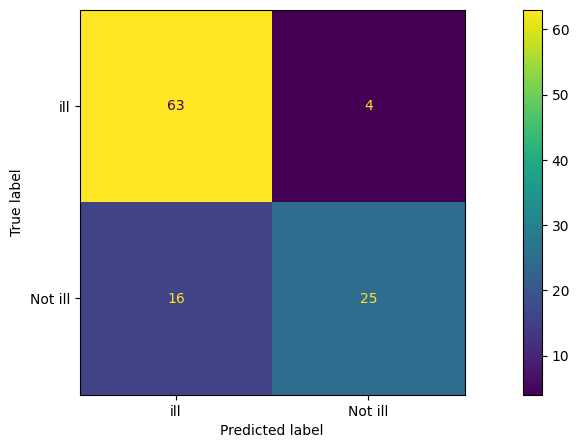

####################  Original Dataset  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 0.6,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

              precision    recall  f1-score   support

           0      0.836     0.836     0.836        67
           1      0.732     0.732     0.732        41

    accuracy                          0.796       108
   macro avg      0.784     0.784     0.784       108
weighted avg      0.796     0.796     0.796       108



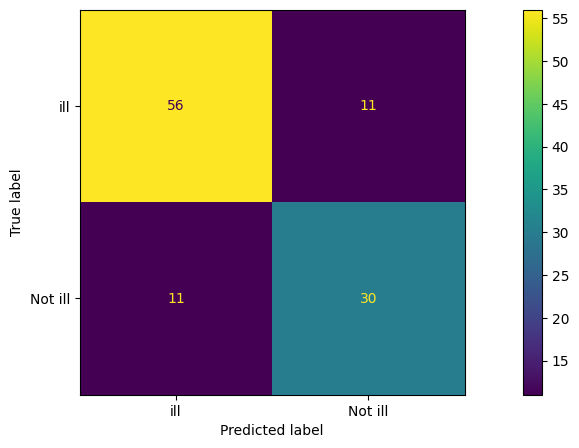

####################  Original Dataset  ####################
Test model:  SVC
Test model parameters:
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0      0.829     0.940     0.881        67
           1      0.875     0.683     0.767        41

    accuracy                          0.843       108
   macro avg      0.852     0.812     0.824       108
weighted avg      0.846     0.843     0.838       108



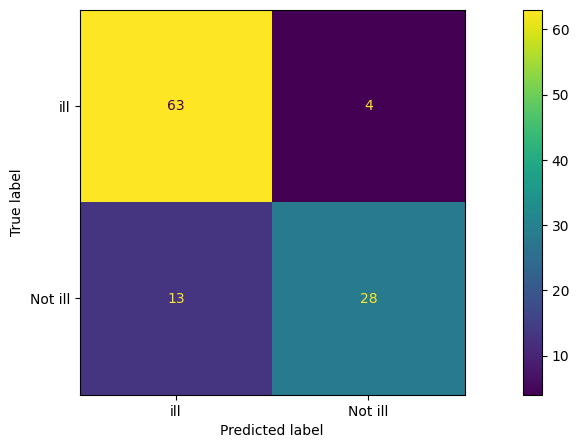

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
####################  Original Dataset  ####################
Test model:  XGBClassifier
Test model parameters:
{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': 8,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.827     0.925     0.873        67
           1      0.848     0.683     0.757        41

    accuracy                          0.833       108
   macro avg     

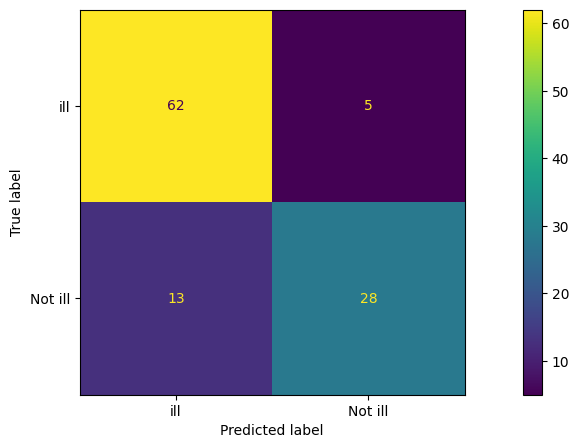

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Original Dataset,RandomForestClassifier,0.788650,0.814815,"{'bootstrap': False, 'max_depth': 3, 'max_feat..."
1,Original Dataset,DecisionTreeClassifier,0.783764,0.796296,"{'criterion': 'entropy', 'max_depth': 3, 'max_..."
2,Original Dataset,SVC,0.824121,0.842593,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}"
3,Original Dataset,XGBClassifier,0.814998,0.833333,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [21]:
ML_results_df = test_ML_models(best_results_df, X_train, y_train, X_test, y_test, "Original Dataset", show_plots=True, debug_mode=True)
ML_results_df

####################  ROS Dataset  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 15}

              precision    recall  f1-score   support

           0      0.836     0.910     0.871        67
           1      0.829     0.707     0.763        41

    accuracy                          0.833       108
   macro avg      0.832     0.809     0.817       108
weighted avg      0.833     0.833     0.830       108



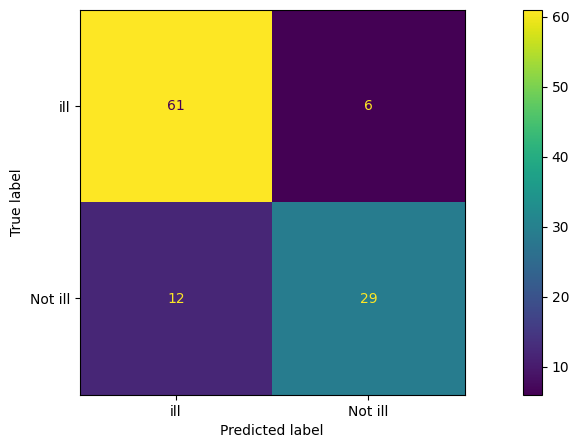

####################  ROS Dataset  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

              precision    recall  f1-score   support

           0      0.753     0.866     0.806        67
           1      0.710     0.537     0.611        41

    accuracy                          0.741       108
   macro avg      0.731     0.701     0.708       108
weighted avg      0.737     0.741     0.732       108



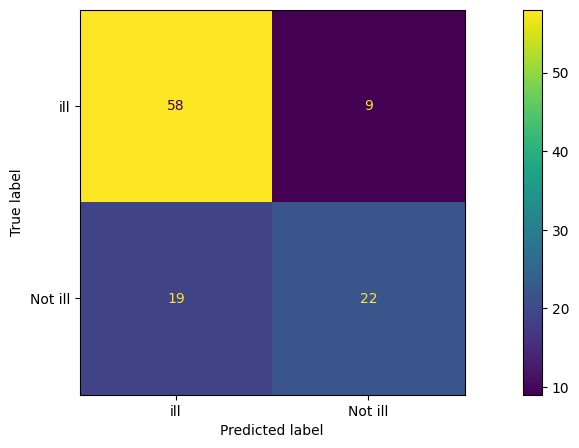

####################  ROS Dataset  ####################
Test model:  SVC
Test model parameters:
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0      0.747     0.881     0.808        67
           1      0.724     0.512     0.600        41

    accuracy                          0.741       108
   macro avg      0.735     0.696     0.704       108
weighted avg      0.738     0.741     0.729       108



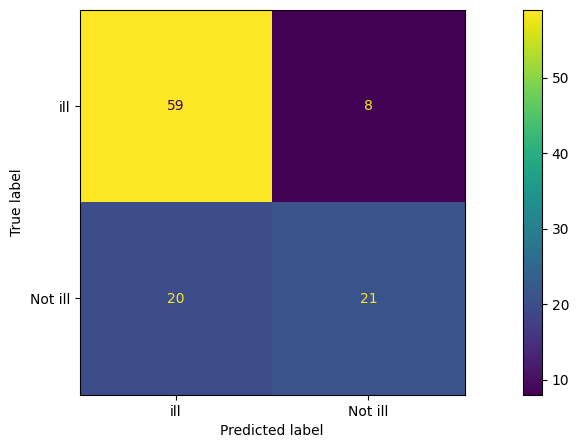

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
####################  ROS Dataset  ####################
Test model:  XGBClassifier
Test model parameters:
{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': 8,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.882     0.896     0.889        67
           1      0.825     0.805     0.815        41

    accuracy                          0.861       108
   macro avg      0.85

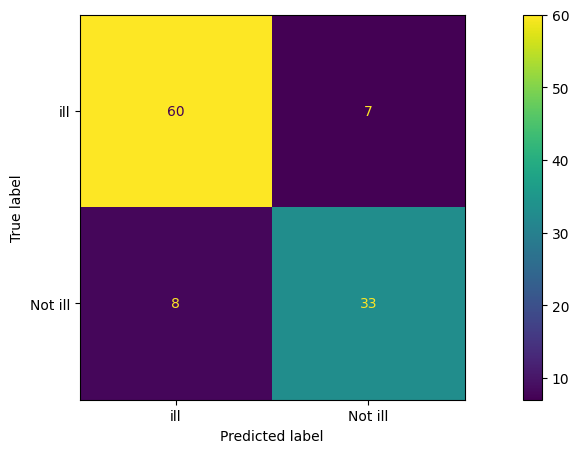

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,ROS Dataset,RandomForestClassifier,0.817293,0.833333,"{'bootstrap': False, 'max_depth': 10, 'max_fea..."
1,ROS Dataset,DecisionTreeClassifier,0.708333,0.740741,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,ROS Dataset,SVC,0.704110,0.740741,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
3,ROS Dataset,XGBClassifier,0.851852,0.861111,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [22]:
ros_ML_results_df = test_ML_models(best_results_df, ros_X_train, ros_y_train, X_test, y_test, "ROS Dataset", show_plots=True, debug_mode=True)
ros_ML_results_df

####################  SMOTE Dataset  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 30}

              precision    recall  f1-score   support

           0      0.855     0.881     0.868        67
           1      0.795     0.756     0.775        41

    accuracy                          0.833       108
   macro avg      0.825     0.818     0.821       108
weighted avg      0.832     0.833     0.832       108



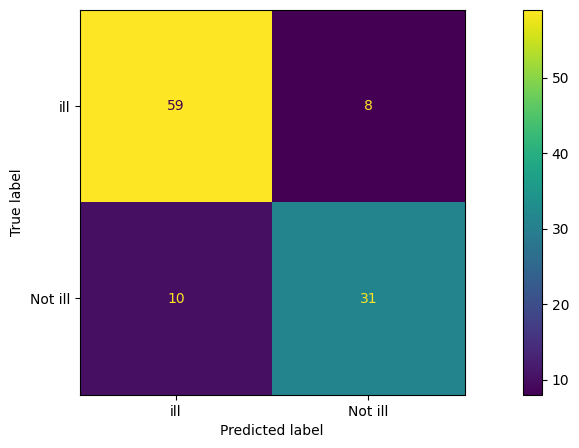

####################  SMOTE Dataset  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6}

              precision    recall  f1-score   support

           0      0.824     0.836     0.830        67
           1      0.725     0.707     0.716        41

    accuracy                          0.787       108
   macro avg      0.774     0.772     0.773       108
weighted avg      0.786     0.787     0.787       108



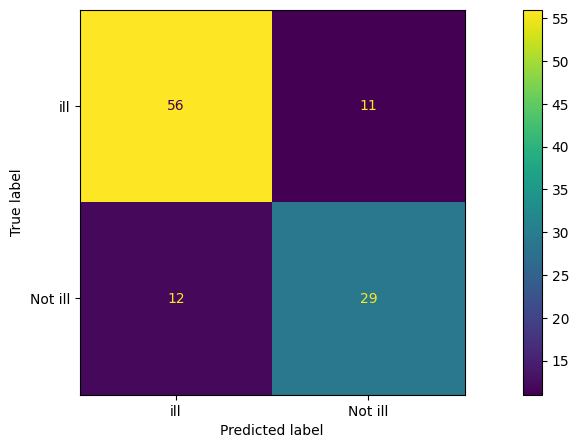

####################  SMOTE Dataset  ####################
Test model:  SVC
Test model parameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0      0.826     0.851     0.838        67
           1      0.744     0.707     0.725        41

    accuracy                          0.796       108
   macro avg      0.785     0.779     0.782       108
weighted avg      0.795     0.796     0.795       108



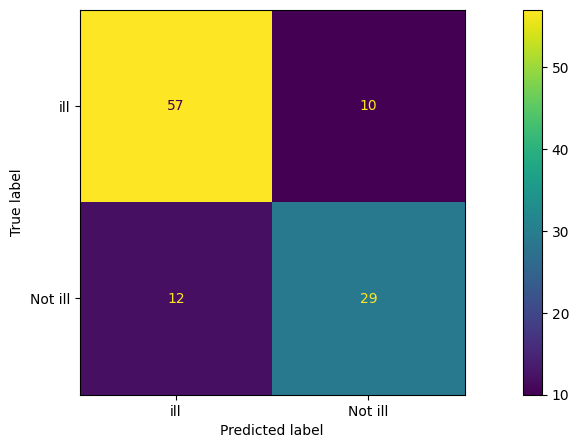

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
####################  SMOTE Dataset  ####################
Test model:  XGBClassifier
Test model parameters:
{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': 8,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.859     0.910     0.884        67
           1      0.838     0.756     0.795        41

    accuracy                          0.852       108
   macro avg      0.

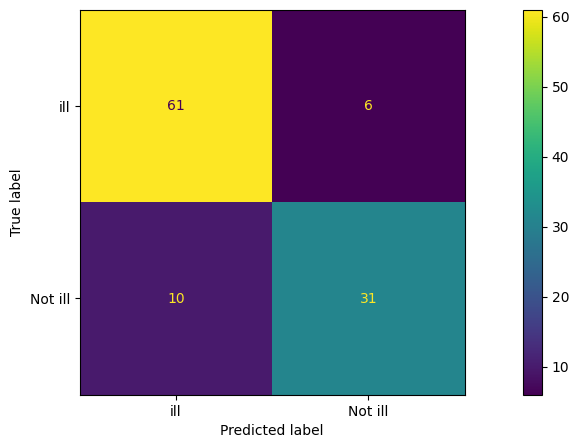

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,SMOTE Dataset,RandomForestClassifier,0.821324,0.833333,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,SMOTE Dataset,DecisionTreeClassifier,0.772840,0.787037,"{'criterion': 'entropy', 'max_depth': 6, 'max_..."
2,SMOTE Dataset,SVC,0.781618,0.796296,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"
3,SMOTE Dataset,XGBClassifier,0.839465,0.851852,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [23]:
smote_ML_results_df = test_ML_models(best_results_df, smote_X_train, smote_y_train, X_test, y_test, "SMOTE Dataset",
                                         show_plots=True, debug_mode=True)
smote_ML_results_df

### Validate DL models

In [24]:
def validate_MLPClassifier(X_train_scaled, y_train, debug_mode=False):
    vmlp = MLPClassifier(max_iter=100, random_state=SEED)

    parameter_space = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
    # parameter_space = {
    #     'hidden_layer_sizes': [(100,)],
    #     'activation': ['tanh'],
    #     'solver': ['adam'],
    #     'alpha': [0.0001],
    #     'learning_rate': ['constant'],
    # }
    clf = GridSearchCV(vmlp,
                       parameter_space,
                       n_jobs=-1,
                       cv=3,
                       scoring={
                           "F1_Score": make_scorer(f1_score, average='macro'),
                           "Accuracy_Score": make_scorer(accuracy_score),
                       },
                       refit="F1_Score")
    clf.fit(X_train_scaled, y_train)

    # All results
    if debug_mode:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    best_index = clf.best_index_
    return clf.best_estimator_,\
           clf.cv_results_["mean_test_F1_Score"][best_index],\
           clf.cv_results_["mean_test_Accuracy_Score"][best_index],\
           clf.best_params_


def test_NN_model(cur_X_train, cur_y_train, cur_X_test, cur_y_test, show_plots, debug_mode):
    model = Sequential()

    model_params = {
        'layers': [
            {'units': 32, 'activation': 'relu'},
            {'units': 16, 'activation': 'relu'},
            {'units': 1, 'activation': 'sigmoid'},
        ],
        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy'],
        'epochs': 200
    }

    # add first hidden layer
    model.add(Dense(model_params['layers'][0]['units'], activation=model_params['layers'][0]['activation'], input_dim=7))
    # Second hidden layer
    model.add(Dense(model_params['layers'][1]['units'], activation=model_params['layers'][1]['activation']))
    # Output layer
    model.add(Dense(model_params['layers'][2]['units'], activation=model_params['layers'][2]['activation']))
    # Compile the model
    model.compile(optimizer=model_params['optimizer'], loss=model_params['loss'], metrics=model_params['metrics'])
    run_hist_2 = model.fit(cur_X_train, cur_y_train, epochs=model_params['epochs'], verbose=0)

    if show_plots:
        fig, ax = plt.subplots()
        ax.plot(run_hist_2.history["loss"], 'r', marker='.', label="Train Loss")
        plt.show()

    # Train and Test accuracy
    train_accuracy = model.evaluate(cur_X_train, cur_y_train, verbose=0)
    test_accuracy = model.evaluate(cur_X_test, cur_y_test, verbose=0)
    if debug_mode:
        print("Training Accuracy: %.2f%%\n" % (train_accuracy[1]*100))
        print("Testing Accuracy: %.2f%%\n" % (test_accuracy[1]*100))

    y_test_pred = model.predict_classes(cur_X_test)
    test_f1_score = f1_score(cur_y_test, y_test_pred, average='macro')
    test_accuracy = accuracy_score(cur_y_test, y_test_pred)

    if show_plots:
        cm = confusion_matrix(cur_y_test, y_test_pred)
        ax = sns.heatmap(cm,
                         annot=True,
                         xticklabels=["Not ill",'ill'],
                         yticklabels=["Not ill",'ill'])
        ax.set_xlabel('Prediction')
        ax.set_ylabel('Actual')
        plt.show()

    return model_params, test_f1_score, test_accuracy, y_test_pred


def test_DL_models(X_train, y_train, X_test, y_test, dataset_title, show_plots=False, debug_mode=False):
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)

    cur_model, cur_f1_score, cur_accuracy, cur_params = validate_MLPClassifier(X_train, y_train, debug_mode)
    MLPClassifier_info = {
        'model_name': 'MLPClassifier',
        'model_params': cur_params
    }
    MLPClassifier_info['test_f1_score'], MLPClassifier_info['test_accuracy'], MLPClassifier_info['model_pred'] =\
        test_evaluation(cur_model, MLPClassifier_info['model_name'], cur_params,
                        X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode)

    if debug_mode:
        print('\nModel name: ', "MLPClassifier")
        print('Best model validation params: ')
        print('Mean Test F1 Score: ', cur_f1_score)
        print('Mean Test Accuracy Score: ', cur_accuracy)
        pprint(cur_params)

    results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    best_f1_score = -np.Inf
    best_model_pred = []
    best_accuracy = -np.Inf
    best_model_name = 'No model'
    best_params = None
    idx = 0
    NN_info = {
        'model_name': 'NN with 2 hidden layers',
    }
    NN_info['model_params'], NN_info['test_f1_score'], NN_info['test_accuracy'], NN_info['model_pred'] =\
        test_NN_model(X_train, y_train, X_test, y_test, show_plots, debug_mode)

    for model_config in [MLPClassifier_info, NN_info]:
        results_df.loc[idx] = [dataset_title,
                               model_config['model_name'],
                               model_config['test_f1_score'],
                               model_config['test_accuracy'],
                               model_config['model_params']]
        idx += 1

        if model_config['test_f1_score'] > best_f1_score:
            best_f1_score = model_config['test_f1_score']
            best_accuracy = model_config['test_accuracy']
            best_model_name = model_config['model_name']
            best_params = model_config['model_params']
            best_model_pred = model_config['model_pred']

    best_results_df.loc[best_results_df.shape[0]] = [dataset_title,
                                                     best_model_name,
                                                     best_f1_score,
                                                     best_accuracy,
                                                     best_params,
                                                     best_model_pred]

    return results_df


In [25]:
test_DL_models(X_train, y_train, X_test, y_test, 'Original Dataset', show_plots=False, debug_mode=False)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hom

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Original Dataset,MLPClassifier,0.837594,0.851852,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde..."
1,Original Dataset,NN with 2 hidden layers,0.788097,0.805556,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [36]:
test_DL_models(ros_X_train, ros_y_train, X_test, y_test, 'ROS Dataset', show_plots=False, debug_mode=False)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Original Dataset,MLPClassifier,0.781618,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
1,Original Dataset,NN with 2 hidden layers,0.776692,0.796296,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [37]:
test_DL_models(smote_X_train, smote_y_train, X_test, y_test, 'SMOTE Dataset', show_plots=False, debug_mode=False)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,SMOTE Dataset,MLPClassifier,0.787478,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
1,SMOTE Dataset,NN with 2 hidden layers,0.766234,0.777778,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [38]:
def display_models_info(best_results_df):
    for i in range(best_results_df.shape[0]):
        model_name, dataset_title, cur_model_pred = best_results_df.at[i, 'Model_Name'], best_results_df.at[i, 'Dataset_Name'],\
                                                    best_results_df.at[i, 'Model_Pred']
        print('\n', "#" * 20, f' {dataset_title} ', "#" * 20)
        print('Model name: ', model_name)

        # title_to_df = {
        #     "Original Dataset": y_test,
        #     "ROS Dataset": ros_y_test,
        #     "SMOTE Dataset": smote_y_test,
        # }
        cur_y_test = y_test

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        # plot the confusion matrix
        cm = confusion_matrix(cur_y_test, cur_model_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
        disp.plot()
        plt.show()

In [39]:
best_results_df

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params,Model_Pred
0,Original Dataset,SVC,0.824121,0.842593,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
1,ROS Dataset,XGBClassifier,0.851852,0.861111,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
2,SMOTE Dataset,XGBClassifier,0.839465,0.851852,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
3,Original Dataset,MLPClassifier,0.837594,0.851852,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
4,Original Dataset,MLPClassifier,0.781618,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
5,SMOTE Dataset,MLPClassifier,0.787478,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."



 ####################  Original Dataset  ####################
Model name:  SVC

              precision    recall  f1-score   support

           0      0.829     0.940     0.881        67
           1      0.875     0.683     0.767        41

    accuracy                          0.843       108
   macro avg      0.852     0.812     0.824       108
weighted avg      0.846     0.843     0.838       108



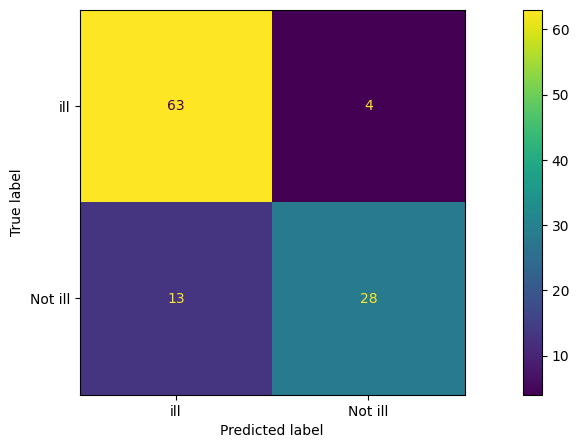


 ####################  ROS Dataset  ####################
Model name:  XGBClassifier

              precision    recall  f1-score   support

           0      0.882     0.896     0.889        67
           1      0.825     0.805     0.815        41

    accuracy                          0.861       108
   macro avg      0.854     0.850     0.852       108
weighted avg      0.861     0.861     0.861       108



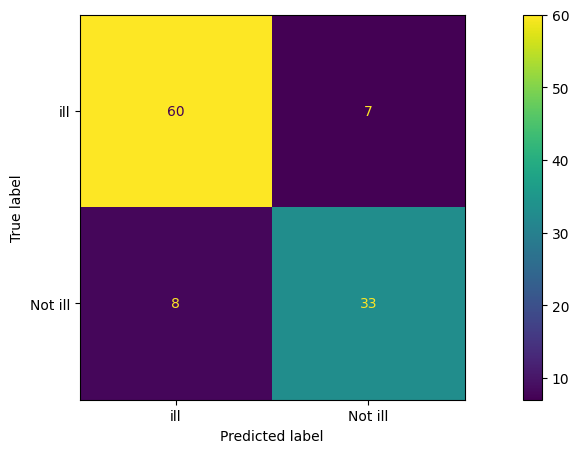


 ####################  SMOTE Dataset  ####################
Model name:  XGBClassifier

              precision    recall  f1-score   support

           0      0.859     0.910     0.884        67
           1      0.838     0.756     0.795        41

    accuracy                          0.852       108
   macro avg      0.848     0.833     0.839       108
weighted avg      0.851     0.852     0.850       108



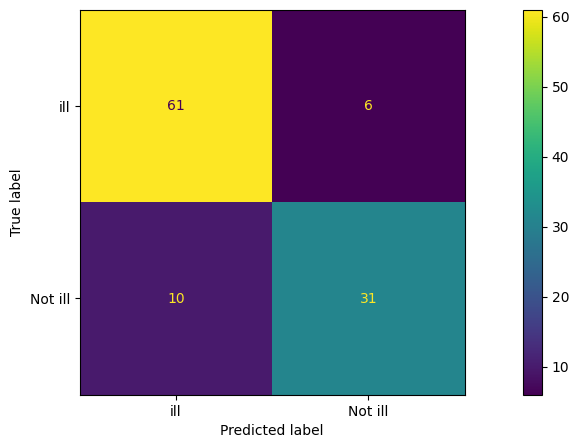


 ####################  Original Dataset  ####################
Model name:  MLPClassifier

              precision    recall  f1-score   support

           0      0.849     0.925     0.886        67
           1      0.857     0.732     0.789        41

    accuracy                          0.852       108
   macro avg      0.853     0.829     0.838       108
weighted avg      0.852     0.852     0.849       108



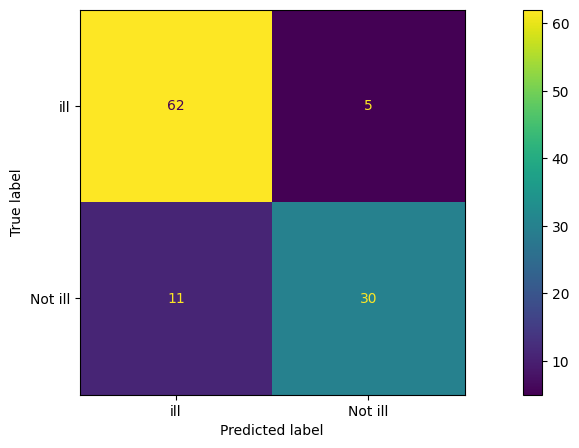


 ####################  Original Dataset  ####################
Model name:  MLPClassifier

              precision    recall  f1-score   support

           0      0.826     0.851     0.838        67
           1      0.744     0.707     0.725        41

    accuracy                          0.796       108
   macro avg      0.785     0.779     0.782       108
weighted avg      0.795     0.796     0.795       108



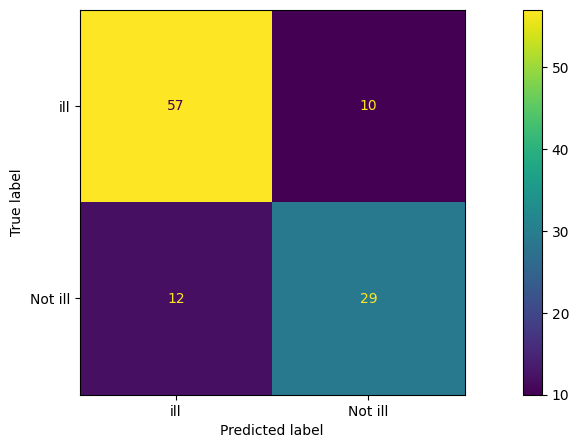


 ####################  SMOTE Dataset  ####################
Model name:  MLPClassifier

              precision    recall  f1-score   support

           0      0.857     0.806     0.831        67
           1      0.711     0.780     0.744        41

    accuracy                          0.796       108
   macro avg      0.784     0.793     0.787       108
weighted avg      0.802     0.796     0.798       108



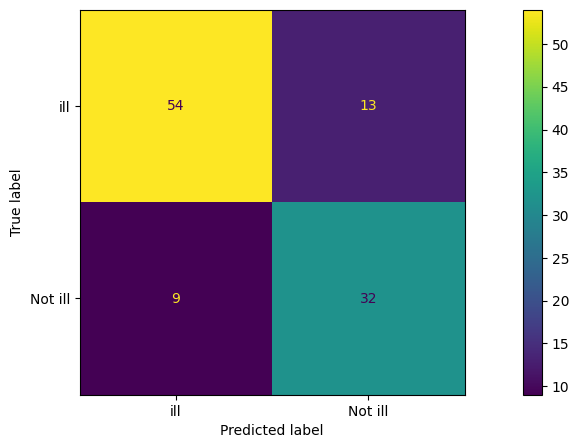

In [40]:
display_models_info(best_results_df)

### LGBM

In [29]:
model = lgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=SEED)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=0,eval_metric='logloss')

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of Light

LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=25)

In [30]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 1.0000
Testing accuracy 0.8333


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

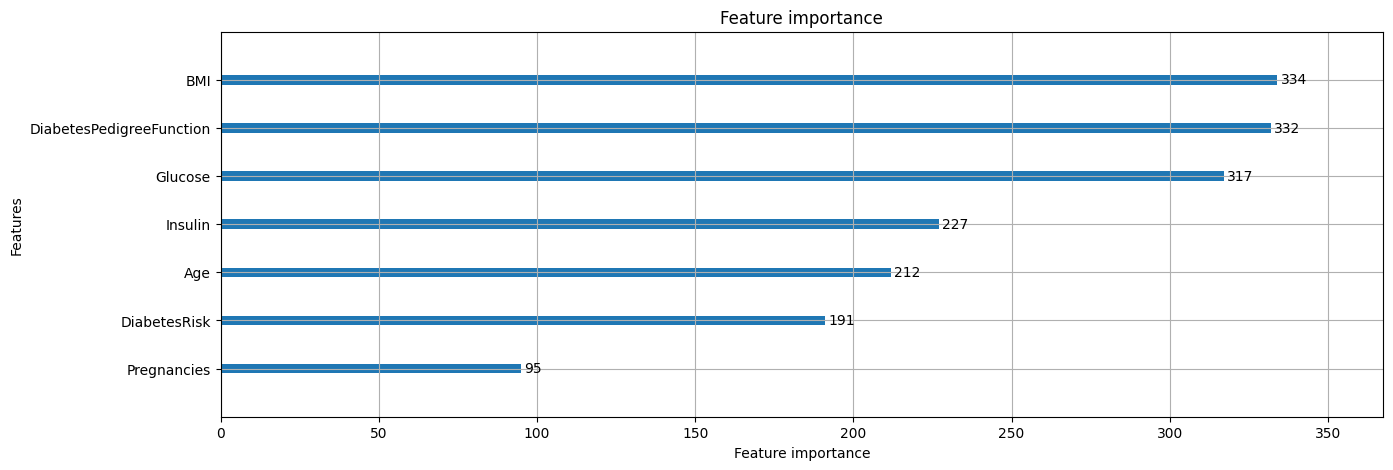

In [31]:
lgbm.plot_importance(model)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

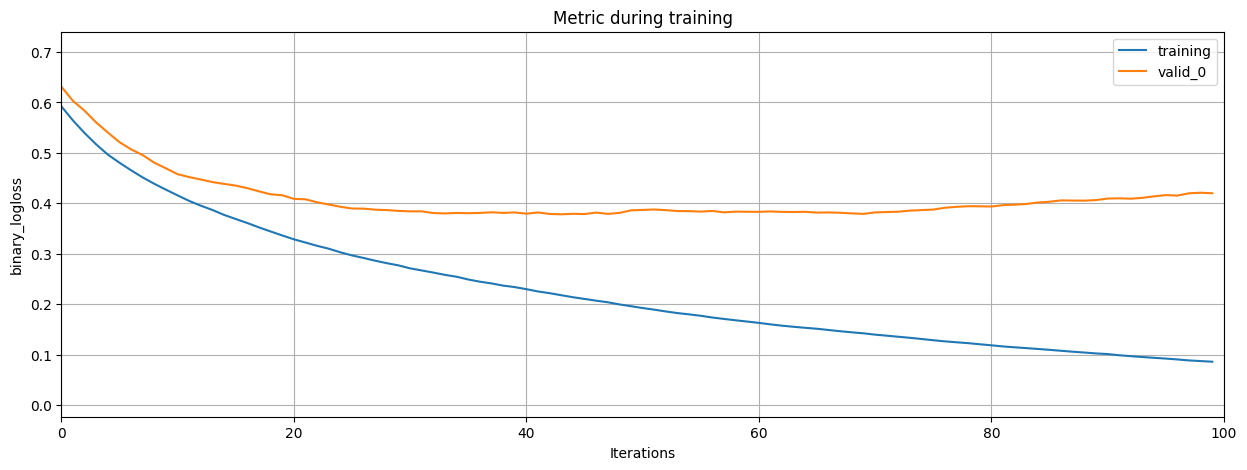

In [32]:
lgbm.plot_metric(model)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        67
           1       0.83      0.71      0.76        41

    accuracy                           0.83       108
   macro avg       0.83      0.81      0.82       108
weighted avg       0.83      0.83      0.83       108



/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


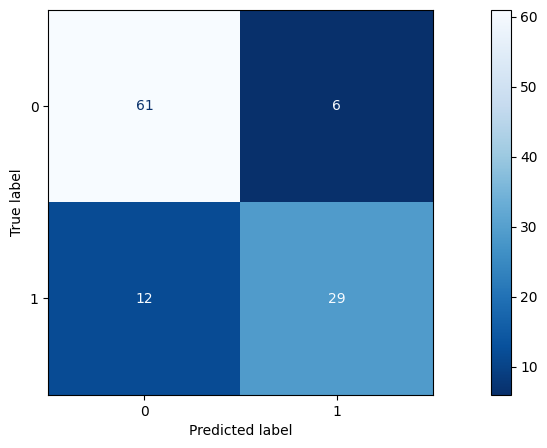

In [33]:
from sklearn import metrics

print(metrics.classification_report(y_test,model.predict(X_test)))
metrics.plot_confusion_matrix(model, X_test, y_test, cmap='Blues_r')

In [34]:
# tensorflow
# keras==2.2.5
# shap==0.30.0

# !pip install tensorflow
# !pip install keras==2.2.5

### Retrain and save model

In [35]:
# x = pd.concat((X_train, X_test))
# y = pd.concat((y_train, y_test))
# best_model.fit(x, y)
# 
# models_path = "models"
# if not os.path.exists(models_path):
#     os.mkdir(models_path)
# pickle.dump(best_model, open(os.path.join(models_path, "diabet_prediction_model.pkl"), "wb"))